In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Weekly Data

### Step 1
First, I just bring in the data from SPY and VIX. The data is from Feb 11 2007 to Feb 11 2022. It is weekly data that I pulled from Yahoo Finance. I remove the Open, High, Low, Close, and Volume columns, as our strtagey is working with Adj Close data.

In [2]:
dfspy = pd.read_csv('SPY.csv',
                index_col=0,       # Tell Pandas that the first column should be used as an index
                parse_dates=[0]    # Tell Pandas to parse the column at index 0 as dates
                )
dfspy = dfspy.drop(columns = ['Open', 'High', 'Low', 'Close', 'Volume'])
dfspy = dfspy.rename(columns = {'Adj Close' : 'SPY Adj Close'})
dfspy

,SPY Adj Close
Date,
2007-02-12,108.318275
2007-02-19,107.998672
2007-02-26,103.070694
2007-03-05,104.639046
2007-03-12,102.966667
...,...
2022-01-10,464.720001
2022-01-17,437.980011
2022-01-24,441.950012


In [3]:
dfvix = pd.read_csv('^VIX.csv',
                index_col=0,       # Tell Pandas that the first column should be used as an index
                parse_dates=[0]    # Tell Pandas to parse the column at index 0 as dates
                )
dfvix = dfvix.drop(columns = ['Open', 'High', 'Low', 'Close', 'Volume'])
dfvix = dfvix.rename(columns = {'Adj Close' : 'VIX Adj Close'})
dfvix

,VIX Adj Close
Date,
2007-02-12,10.020000
2007-02-19,10.580000
2007-02-26,18.610001
2007-03-05,14.090000
2007-03-12,16.790001
...,...
2022-01-10,19.190001
2022-01-17,28.850000
2022-01-24,27.660000


### Step 2
I merge the dataframes of SPY and VIX data. I then split the data into a 70-30 split. 

In [4]:
df = dfspy.join(dfvix, on='Date')
dftrain = df[:(int(0.7*len(df)))]
dftest = df[(int(0.7*len(df))):]
dftrain.head()

,SPY Adj Close,VIX Adj Close
Date,,
2007-02-12,108.318275,10.020000
2007-02-19,107.998672,10.580000
2007-02-26,103.070694,18.610001
2007-03-05,104.639046,14.090000
2007-03-12,102.966667,16.790001


### Step 3
The code for the strategy function

In [21]:
def strategy(df_og, ema_span=(6,12), sig_span=6, quant1=0.1, quant2=0.6, vix_span=50, cash=1000000):
    df = df_og.copy()
    df = df.reset_index()
    df['12EMA'] = df['SPY Adj Close'].ewm(span = ema_span[0], adjust = False).mean()
    df['26EMA'] = df['SPY Adj Close'].ewm(span = ema_span[1], adjust = False).mean()
    df['MACD'] = df['12EMA'] - df['26EMA']
    df['Signal'] = df['MACD'].ewm(span = sig_span, adjust = False).mean()
    df['Long'] = np.where(((df['MACD'] > df['Signal']) &
                               ((df['MACD'] < 0) |
                                df['VIX Adj Close'] < df['VIX Adj Close'].rolling(vix_span).quantile(quant1))),1,0)
    df['Short'] = np.where(((df['MACD'] < df['Signal']) &
                               (df['VIX Adj Close'] > df['VIX Adj Close'].rolling(vix_span).quantile(quant2))), -1, 0)

    df['Position'] = df['Long'] + df['Short']
    df.loc[:, 'Cash'] = cash
    df['Order'] = df['Position'].diff()
    df.loc[:, 'Position_value'] = 0

    for index, row in df.iterrows():
        if (int(index) > 0):
            if (df.loc[index, 'Order'] == 1):
                if (df.loc[index, 'Position'] == 1):
                    df.loc[index, 'Position_value'] = df.shift(1).loc[index, 'Position_value'] + df.shift(1).loc[index, 'Cash']
                    df.loc[index, 'Cash'] = 0
                elif (df.loc[index, 'Position'] == 0):
                    df.loc[index, 'Cash'] = df.shift(1).loc[index, 'Cash'] + df.shift(1).loc[index, 'Position_value']
                    df.loc[index, 'Position_value'] = 0
            elif (df.loc[index, 'Order'] == -1):
                if (df.loc[index, 'Position'] == 0):
                    df.loc[index, 'Cash'] = df.shift(1).loc[index, 'Cash'] + df.shift(1).loc[index, 'Position_value']
                    df.loc[index, 'Position_value'] = 0
                elif (df.loc[index, 'Position'] == -1):
                    df.loc[index, 'Position_value'] = df.shift(1).loc[index, 'Position_value'] - df.shift(1).loc[index, 'Cash']
                    df.loc[index, 'Cash'] = 2*(df.shift(1).loc[index, 'Cash'])
            elif (df.loc[index, 'Order'] == 2):
                df.loc[index, 'Position_value'] = df.shift(1).loc[index, 'Cash'] + df.shift(1).loc[index, 'Position_value']
                df.loc[index, 'Cash'] = 0
            elif (df.loc[index, 'Order'] == -2):
                df.loc[index, 'Position_value'] = (-1)*df.shift(1).loc[index, 'Position_value']
                df.loc[index, 'Cash'] = ((2)*df.shift(1).loc[index, 'Position_value'])
            elif (df.loc[index, 'Order'] == 0):
                if (df.loc[index, 'Position'] == 1):
                    df.loc[index, 'Position_value'] = df.shift(1).loc[index, 'Position_value']*(df.loc[index, 'SPY Adj Close']/df.shift(1).loc[index, 'SPY Adj Close'])
                    df.loc[index, 'Cash'] = df.shift(1).loc[index, 'Cash']
                elif (df.loc[index, 'Position'] == -1):
                    df.loc[index, 'Position_value'] = df.shift(1).loc[index, 'Position_value']*(df.loc[index, 'SPY Adj Close']/df.shift(1).loc[index, 'SPY Adj Close'])
                    df.loc[index, 'Cash'] = df.shift(1).loc[index, 'Cash']
                elif (df.loc[index, 'Position'] == 0):
                    df.loc[index, 'Position_value'] = 0
                    df.loc[index, 'Cash'] = df.shift(1).loc[index, 'Cash']
    
    df['Portfolio_value'] = df['Position_value'] + df['Cash']
    df['Strategy Returns'] = (df['Portfolio_value'] - cash)/cash
    df['SPY Returns'] = (df['SPY Adj Close'] - df.loc[0, 'SPY Adj Close'])/df.loc[0, 'SPY Adj Close']
    return df

In [27]:
train = strategy(dftrain, cash=1000)
train

,Date,SPY Adj Close,VIX Adj Close,12EMA,26EMA,MACD,Signal,Long,Short,Position,Cash,Order,Position_value,Portfolio_value,Strategy Returns,SPY Returns
0,2007-02-12,108.318275,10.020000,108.318275,108.318275,0.000000,0.000000,0,0,0,1000.000000,NaN,0.000000,1000.000000,0.000000,0.000000
1,2007-02-19,107.998672,10.580000,108.226960,108.269105,-0.042145,-0.012042,0,0,0,1000.000000,0.0,0.000000,1000.000000,0.000000,-0.002951
2,2007-02-26,103.070694,18.610001,106.753741,107.469350,-0.715609,-0.213061,0,0,0,1000.000000,0.0,0.000000,1000.000000,0.000000,-0.048446
3,2007-03-05,104.639046,14.090000,106.149542,107.033918,-0.884376,-0.404865,0,0,0,1000.000000,0.0,0.000000,1000.000000,0.000000,-0.033967
4,2007-03-12,102.966667,16.790001,105.240149,106.408187,-1.168038,-0.622914,0,0,0,1000.000000,0.0,0.000000,1000.000000,0.000000,-0.049406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,2017-07-10,226.823593,9.510000,224.201014,222.300652,1.900363,1.920676,0,0,0,5154.669974,0.0,0.000000,5154.669974,4.154670,1.094047
544,2017-07-17,228.042862,9.360000,225.298685,223.184069,2.114616,1.976087,1,0,1,0.000000,1.0,5154.669974,5154.669974,4.154670,1.105304
545,2017-07-24,228.070602,10.290000,226.090661,223.935843,2.154818,2.027153,1,0,1,0.000000,0.0,5155.297007,5155.297007,4.155297,1.105560
546,2017-07-31,228.532455,10.030000,226.788317,224.643014,2.145303,2.060910,1,0,1,0.000000,0.0,5165.736711,5165.736711,4.165737,1.109824


In [28]:
def results(df, per_year=52, rfr=0.02):
    train = df.copy()
#     i = 0
#     for index, row in df.iterrows():
#         if (row['Position'] == 0):
#             i = i + 1
#         else:
#             break
#     train = train[i:]
    train['Strategy P&L'] = train['Strategy Returns'].diff()
    train['SPY P&L'] = train['SPY Returns'].diff()
    print("Mean Strategy P&L: ", train['Strategy P&L'].mean())
    print("Mean SPY P&L:      ", train['SPY P&L'].mean())
    print("")
    print("Volatility of Strategy P&L: ", train['Strategy P&L'].std())
    print("Volatility of SPY P&L:      ", train['SPY P&L'].std())
    print("")
    print("Median Strategy P&L: ", train['Strategy P&L'].median())
    print("Median SPY P&L:      ", train['SPY P&L'].median())
    print("")
    rfr_n = ((rfr+1)**(1/per_year) - 1)
    print('RFR in n=%d periods per year:' % per_year, rfr_n)
    print("Strategy Sharpe Ratio (annualized): ", (train['Strategy P&L'].mean() - rfr_n)*np.sqrt(per_year)/(train['Strategy P&L'].std()))
    print("SPY Sharpe Ratio (annualized):      ", (train['SPY P&L'].mean() - rfr_n)*np.sqrt(per_year)/(train['SPY P&L'].std()))
    print("")
    print("Our positions' frequency are as follows: ")
    tp = pd.DataFrame(train['Position'].value_counts())
    print(tp)
    fig, ax = plt.subplots()
    train['Position'].value_counts().plot(ax=ax, kind='bar')
    print("")
    pnl = pd.DataFrame({'SPY':train['SPY Returns'],
                   'Strategy':train['Strategy Returns']})
    pnl.plot()
    pnl.diff().plot()
    print("")
    position = pd.DataFrame({'Position': train['Position']})
    position.plot()    

Mean Strategy P&L:  0.007615606417946871
Mean SPY P&L:       0.0019776369334406534

Volatility of Strategy P&L:  0.03791217364756934
Volatility of SPY P&L:       0.024988600426905417

Median Strategy P&L:  0.0
Median SPY P&L:       0.0032090152838936126

RFR in n=52 periods per year: 0.0
Strategy Sharpe Ratio (annualized):  1.4485299465503225
SPY Sharpe Ratio (annualized):       0.5706979379360684

Our positions' frequency are as follows: 
    Position
 1       269
 0       168
-1       111




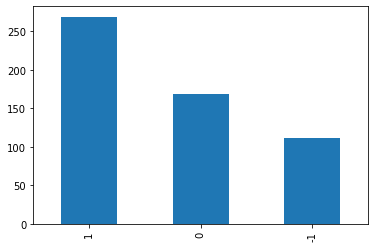

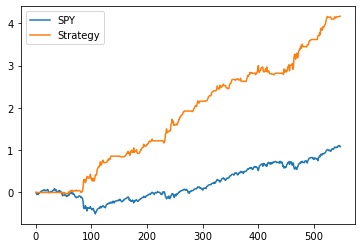

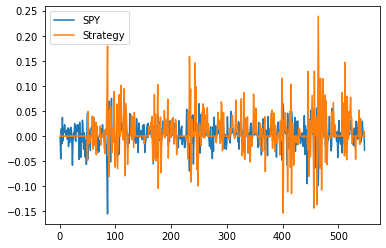

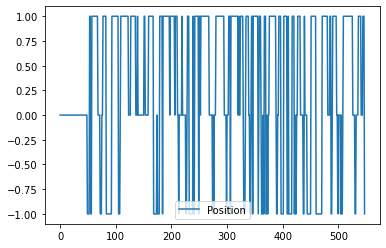

In [34]:
train = strategy(dftrain)
results(train, 52, 0)

In [16]:
test = strategy(dftest)
test.tail()

,Date,SPY Adj Close,VIX Adj Close,12EMA,26EMA,MACD,Signal,Long,Short,Position,Cash,Order,Position_value,Portfolio_value,Strategy Returns,SPY Returns
230,2022-01-10,464.720001,19.190001,461.993172,450.472433,11.520739,12.340836,0,0,0,1.421107e+06,0.0,0.000000e+00,1.421107e+06,0.421107,1.072875
231,2022-01-17,437.980011,28.850000,458.298840,449.547068,8.751771,11.623023,0,-1,-1,2.842215e+06,-1.0,-1.421107e+06,1.421107e+06,0.421107,0.953601
232,2022-01-24,441.950012,27.660000,455.783635,448.984323,6.799312,10.658281,0,-1,-1,2.842215e+06,0.0,-1.433989e+06,1.408226e+06,0.408226,0.971309
233,2022-01-31,448.700012,23.219999,454.693847,448.963263,5.730584,9.672742,0,0,0,1.408226e+06,1.0,0.000000e+00,1.408226e+06,0.408226,1.001418
234,2022-02-07,449.320007,23.910000,453.867103,448.989689,4.877414,8.713676,0,0,0,1.408226e+06,0.0,0.000000e+00,1.408226e+06,0.408226,1.004183


Mean Strategy P&L:  0.006203164783467971
Mean SPY P&L:       0.004291381174641822

Volatility of Strategy P&L:  0.03025874930472419
Volatility of SPY P&L:       0.03537855366158788

Median Strategy P&L:  0.0
Median SPY P&L:       0.007459034298981929

RFR in n=52 periods per year: 0.0
Strategy Sharpe Ratio (annualized):  1.4783049009533482
SPY Sharpe Ratio (annualized):       0.8746991194573054

Our positions' frequency are as follows: 
    Position
 1       107
 0        83
-1        45




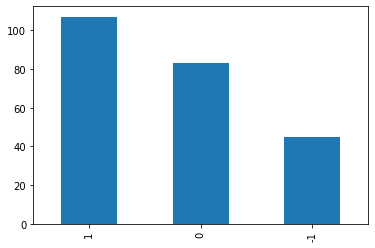

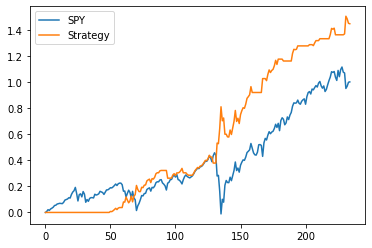

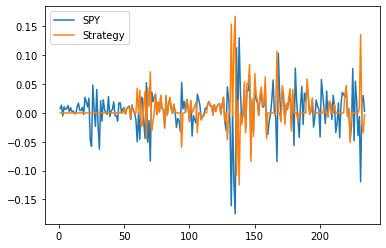

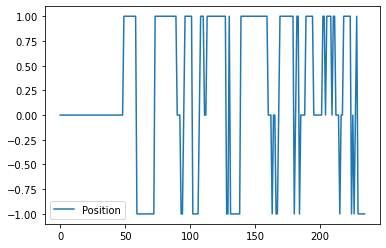

In [35]:
test = strategy(dftest)
results(test, 52, 0)

## Now we use Daily Data

In [31]:
df2spy = pd.read_csv('SPY (1).csv',
                index_col=0,       # Tell Pandas that the first column should be used as an index
                parse_dates=[0]    # Tell Pandas to parse the column at index 0 as dates
                )
df2spy = df2spy.drop(columns = ['Open', 'High', 'Low', 'Close', 'Volume'])
df2spy = df2spy.rename(columns = {'Adj Close' : 'SPY Adj Close'})

df2vix = pd.read_csv('^VIX (1).csv',
                index_col=0,       # Tell Pandas that the first column should be used as an index
                parse_dates=[0]    # Tell Pandas to parse the column at index 0 as dates
                )
df2vix = df2vix.drop(columns = ['Open', 'High', 'Low', 'Close', 'Volume'])
df2vix = df2vix.rename(columns = {'Adj Close' : 'VIX Adj Close'})

df2 = df2spy.join(df2vix, on='Date')
df2train = df2[:(int(0.7*len(df2)))]
df2test = df2[(int(0.7*len(df2))):]

Mean Strategy P&L:  0.006033941887267242
Mean SPY P&L:       0.0004206341230283661

Volatility of Strategy P&L:  0.043731056541258126
Volatility of SPY P&L:       0.012530735786631905

Median Strategy P&L:  0.0
Median SPY P&L:       0.0007743592757305795

RFR in n=252 periods per year: 0.0
Strategy Sharpe Ratio (annualized):  2.1903394413619948
SPY Sharpe Ratio (annualized):       0.5328785003996649

Our positions' frequency are as follows: 
    Position
 1      1257
 0       741
-1       646




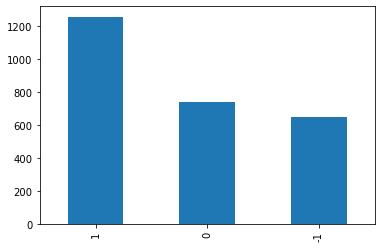

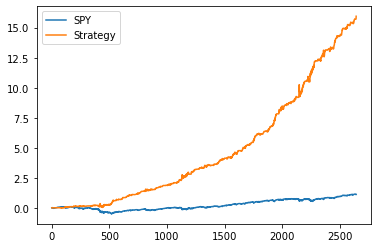

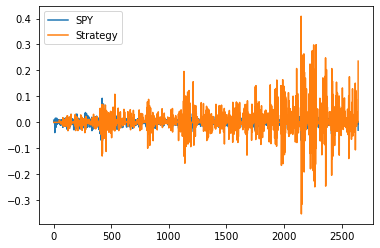

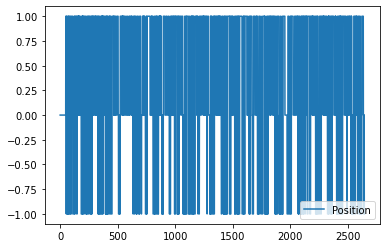

In [36]:
train2 = strategy(df2train)
results(train2, 252, 0)

Mean Strategy P&L:  0.0047279189922556815
Mean SPY P&L:       0.0008760879352950529

Volatility of Strategy P&L:  0.02905526702170805
Volatility of SPY P&L:       0.016298673588072302

Median Strategy P&L:  0.0
Median SPY P&L:       0.0013915347588182303

RFR in n=252 periods per year: 0.0
Strategy Sharpe Ratio (annualized):  2.583125020951667
SPY Sharpe Ratio (annualized):       0.8532881369356524

Our positions' frequency are as follows: 
    Position
 1       546
 0       295
-1       293




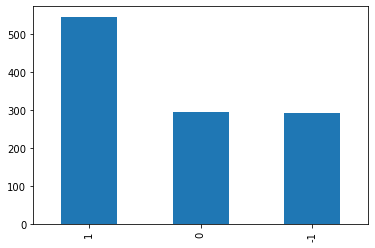

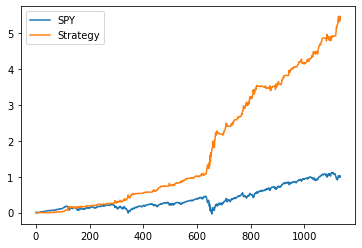

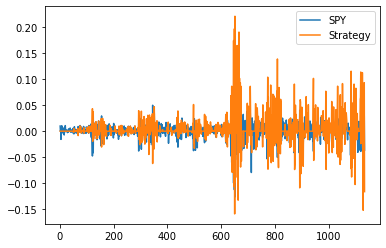

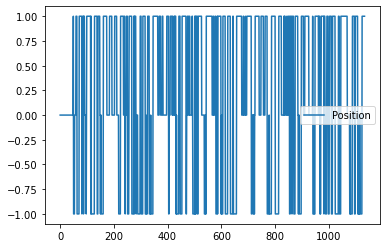

In [37]:
test2 = strategy(df2test)
results(test2, 252, 0)